In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel

sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, solve_ivp_discrete, \
                    smooth_dap, sol_ivp_wrapper, smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont


from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad


%load_ext autoreload
%autoreload 2

# Data

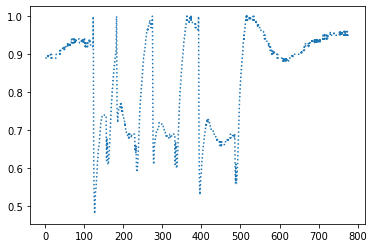

In [2]:
data_full = pd.read_csv('../../data/high_tc_20190913.csv', sep = ';', encoding="latin1", header = 0, index_col = 0)


data_full.index = pd.to_datetime(data_full.index, format='%Y-%m-%d %H:%M:%S')
data = data_full.filter(['A40_A_CompCap'], axis=1)
data['A40_A_CompCap'] = data['A40_A_CompCap']/100
data['t'] = 60 * data_full.index.hour + data_full.index.minute + 1/60 * data_full.index.second
data['t'] = data['t'] - data['t'][0]


plt.plot(data['t'], data['A40_A_CompCap'], ls = 'dotted')

# First order model

In [3]:
# Define model
lambda_MELT = 0.00183*60
lambda_IDLE = 0.00085*60
mu_MELT = 66.92400 
mu_IDLE = 94.89100
sigma = 0.28130
R = 1.96580
pars = np.array([mu_IDLE, mu_MELT, lambda_IDLE, lambda_MELT, sigma, R])
m1 = firstordermodel(pars)

tf = 60 * 24
x0 = np.array(90)


# Extract switch solution from C++
switches = genfromtxt('../results/optimal_pars.csv', delimiter=',')
tau_MELT_all, tau_IDLE_all  = derive_regimes(switches,tf,1)
tau_MELT, tau_IDLE  = derive_regimes(switches,tf,0)
switches = np.concatenate((tau_MELT, tau_IDLE))

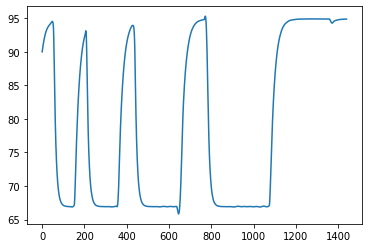

In [4]:
# Plot solution
t_eval = np.linspace(0,tf,1000)
sol = solve_ivp(m1.f, [0, tf], [x0], args=(switches,),t_eval=t_eval)
plt.plot(sol.t,sol.y[0])

# Objective function

In [5]:
# Day Ahead Prices and power constants
dap = 1/1000000 * np.array([15.5,31.,21.,35.,36.,35.,28.,33.,28.,41.,44.,36.,32.,28.,24.,25.,34.,36.,41.,37.,35.,39.,34.,24.])
dap = 1/1000000 * (10 + 6.8 * np.array([12.5,0.01,0.125,0.12,12.4,12.3,2.3,4,12.6,11,12.5,10,12.6,11,7.5,5,11.8,2.4,0.3,7.6,0.3,2,4,12.5]))
k = 12400.
k_MELT = 250.
k_IDLE = 9.

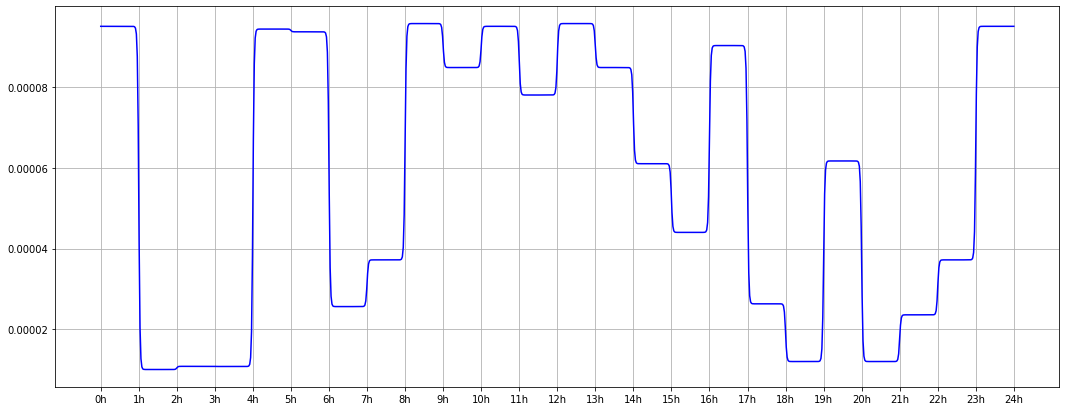

In [6]:
t = np.linspace(0,tf,1000)
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(t,smooth_dap(t,dap),color='b')
ax.set_xticks(np.arange(0,dap.size+1,1)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,dap.size+1,1) * 60.])
ax.grid()

# Objective function

In [7]:
def obj(switches,model,x0,k,k_MELT,k_IDLE,dap,tf,dt):
    #switches = mergeSwitchCont(switches)
    
    nx = x0.size
    if nx > 1:
        start = [x0[i] for i in range(nx)]
    else:
        start = [x0]
        
    #print(switches)
    T = np.linspace(0,tf,int(tf/dt))
    sol = solve_ivp(m1.f, [0, tf], start, args=(switches,),t_eval=T)
    Z = sol.y[0]
    
    cost_momental, cost_acc = cost(Z/100,T,switches,dap,k,k_MELT,k_IDLE)
    
    return(cost_acc[-1])

x0 = np.array(24.)
tf = 24.*60.

switch = np.array([100., 350., 500., 650., 900.,150., 400., 600., 800., 1000.])
#switch = np.array([25., 75., 125., 175, 125., 175, 125., 175, 125., 175, 125., 175, 125., 175, 125., 175
obj_val = obj(switches,m1,x0,k,k_MELT,k_IDLE,dap,tf,0.01)
obj_val

13.248610758448782

# Constraints

In [8]:
switch

array([ 100.,  350.,  500.,  650.,  900.,  150.,  400.,  600.,  800.,
       1000.])

In [9]:
def consMatrix(n_s,tf,max_melt):
    #nswitch = len(tau)
    n_s_all = 2*n_s
    A = np.zeros((n_s_all+2,n_s_all))
    A[:n_s_all,:n_s_all] += + -1 * np.eye(n_s_all)
    A[:n_s,n_s:] += + np.eye(n_s)
    A[(n_s+1):(n_s_all+1),:n_s] += np.eye(n_s)
    A[-1,:] = np.concatenate((np.ones(n_s),-1 * np.ones(n_s)))
    
    A = np.hstack((A[:,n_s:],A[:,:n_s])) # Let [tau_idle , tau_melt]' become [tau_melt, tau_idle]' 
    
    ub = np.zeros(n_s_all + 2)
    ub[-2] = tf
    ub[-1] = max_melt
    
    return(A,ub)

# Optimize without gradients

In [10]:
n_s = 5
max_melt = 8*60
A,b = consMatrix(n_s,tf,max_melt)
cons = sc_opt.LinearConstraint(A, -np.inf, b,keep_feasible=True)
A,b
#print(A.dot(tau0))
#A.dot(tau0) <= b

(array([[ 1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.]]),
 array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 1440.,  480.]))

In [11]:
# construct initial guess that satifies cnstraints
idle = tf * np.linspace(0.1,0.8,n_s)
melt = idle - max_melt/n_s * 0.9
tau0 = np.concatenate((melt,idle))
tau0

array([  57.6,  309.6,  561.6,  813.6, 1065.6,  144. ,  396. ,  648. ,
        900. , 1152. ])

In [ ]:
res_nograd = sc_opt.minimize(obj, tau0, args=(m1,x0,k,k_MELT,k_IDLE,dap,tf,0.01),method='trust-constr',constraints=cons,\
options={'gtol': 1e-8, 'xtol': 1e-8, 'disp': True, 'verbose' : 2, 'initial_tr_radius' : 10,\
                              'maxiter': 10})

In [ ]:
switch_opt = res_nograd.x

In [ ]:
switch_opt[n_s:],switch_opt[:n_s],

In [ ]:
# PLOT SOLUTION AND PRICE
t_eval = np.linspace(0,tf,1000)
sol = solve_ivp(m1.f, [0, tf], [x0], args=(switch_opt,),t_eval=t_eval)
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(sol.t,sol.y[0])
ax.plot(sol.t,smooth_dap(sol.t,dap) * 400000,color='b')
ax.set_xticks(np.arange(0,dap.size+1,1)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,dap.size+1,1) * 60.])
ax.grid()

In [ ]:
# Plot solution
t_eval = np.linspace(0,tf,1000)
sol = solve_ivp(m1.f, [0, tf], [x0], args=(switch_opt,),t_eval=t_eval)
plt.plot(sol.t,sol.y[0])
plt.plot(switch_opt[:n_s],np.array([np.min(sol.y[0]) for i in range(n_s)]),'bo',label = 'MELT',alpha = 0.5)
plt.plot(switch_opt[n_s:],np.array([np.min(sol.y[0]) for i in range(n_s)]),'r*',label = 'IDLE',alpha = 0.5)

plt.legend()

# Same problem solved with ipopt - bounded

In [ ]:
# PLOT SOLUTION AND PRICE
t_eval = np.linspace(0,tf,1000)
sol = solve_ivp(m1.f, [0, tf], [x0], args=(switches_ipopt_bnd,),t_eval=t_eval)
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(sol.t,sol.y[0])
ax.plot(sol.t,smooth_dap(sol.t,dap) * 1500000,color='b')
ax.set_xticks(np.arange(0,dap.size+1,1)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,dap.size+1,1) * 60.])
ax.grid()

In [ ]:
# Plot solution
t_eval = np.linspace(0,tf,1000)
sol = solve_ivp(m1.f, [0, tf], [x0], args=(switches_ipopt_bnd,),t_eval=t_eval)
plt.plot(sol.t,sol.y[0])
plt.plot(switches_ipopt_bnd[:n_s],np.array([np.min(sol.y[0]) for i in range(n_s)]),'bo',label = 'MELT',alpha = 0.5)
plt.plot(switches_ipopt_bnd[n_s:],np.array([np.min(sol.y[0]) for i in range(n_s)]),'r*',label = 'IDLE',alpha = 0.5)

plt.legend()

# Same problem solved with ipopt - bounded with melt max

[ True  True  True  True  True  True  True  True  True  True  True False] 1162.5679507300001


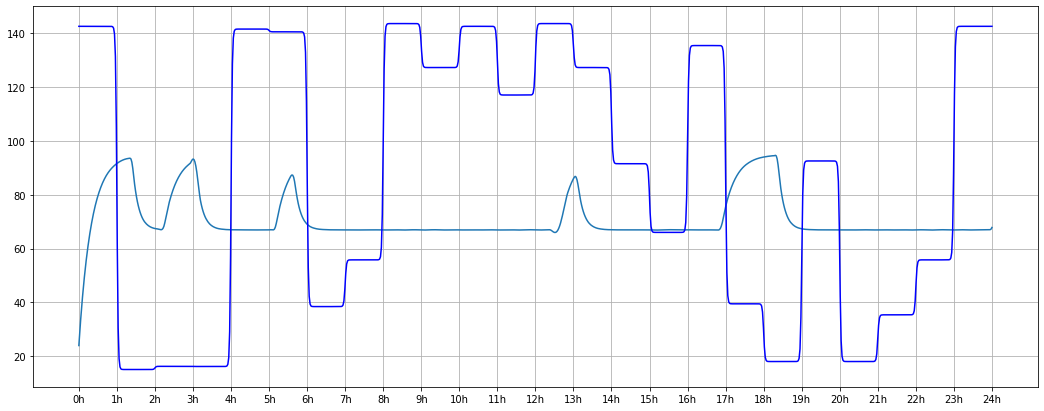

In [21]:
switches_ipopt = np.array([  83.61538197,  184.23867324,  338.6965773 ,  785.01067173,
       1101.66303198,  133.69078633,  309.5468121 ,  760.63990184,
       1011.91478668, 1440.        ])
print(A.dot(switches_ipopt) <= b, A.dot(switches_ipopt)[-1])
# PLOT SOLUTION AND PRICE
t_eval = np.linspace(0,tf,1000)
sol = solve_ivp(m1.f, [0, tf], [x0], args=(switches_ipopt,),t_eval=t_eval)
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(sol.t,sol.y[0])
ax.plot(sol.t,smooth_dap(sol.t,dap) * 1500000,color='b')
ax.set_xticks(np.arange(0,dap.size+1,1)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,dap.size+1,1) * 60.])
ax.grid()

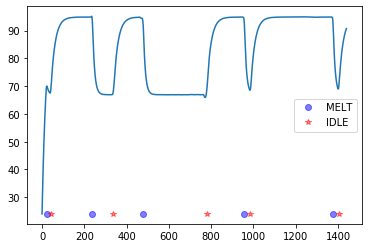

In [16]:
# Plot solution
t_eval = np.linspace(0,tf,1000)
sol = solve_ivp(m1.f, [0, tf], [x0], args=(switches_ipopt,),t_eval=t_eval)
plt.plot(sol.t,sol.y[0])
plt.plot(switches_ipopt[:n_s],np.array([np.min(sol.y[0]) for i in range(n_s)]),'bo',label = 'MELT',alpha = 0.5)
plt.plot(switches_ipopt[n_s:],np.array([np.min(sol.y[0]) for i in range(n_s)]),'r*',label = 'IDLE',alpha = 0.5)

plt.legend()

13.46163807700349


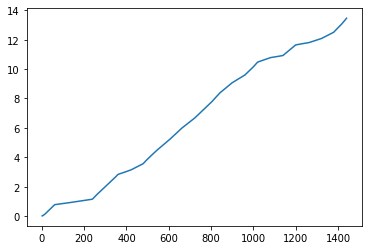

In [17]:
T = np.linspace(0,tf,1000)
cost_momental, cost_acc = cost(sol.y[0]/100,T,switches_ipopt,dap,k,k_MELT,k_IDLE)
plt.plot(T[1:],cost_acc)
print(cost_acc[-1])

# Construct gradients

In [ ]:
def obj_grad(switches,model,x0,k,k_MELT,k_IDLE,dap,tf,dt):
    print(switches)
    n_s = int(len(switches)/2)
    dummy_t = 0

    #obj(switches,model,x0,k,k_MELT,k_IDLE,dap,tf,dt)
    #def obj_grad2(switches,tf,x0,model,k,k_MELT,k_IDLE)

    tau_MELT, tau_IDLE = switches[:n_s], switches[n_s:]
    #print(switches,tau_MELT,tau_IDLE)

    # Cosrt function with respect to x
    c_wrt_x = lambda t, dap, k : k * smooth_dap(t,dap)


    # Define lambda ODE
    lambda_dot = lambda t, lambda_fun, model, switches, dap, k : \
                    -model.f_wrt_x(t,0,switches)*lambda_fun - c_wrt_x(t,dap,k)



    # Derive MELT and IDLE switches
    #tau_MELT, tau_IDLE = derive_regimes(switches,dummy_t,0)


    # Solve lambda ODE for MELT
    sol = solve_ivp(lambda_dot, [tf,0], [0], t_eval=np.flip(tau_MELT), args = (m1,switches,dap,k))
    lambda_MELT = np.flip(sol.y[0])
    
    # Solve lambda ODE for MELT
    sol = solve_ivp(lambda_dot, [tf,0], [0], t_eval=np.flip(tau_IDLE), args = (m1,switches,dap,k), vectorized=True)
    lambda_IDLE = np.flip(sol.y[0])

    
    # Solve process ODE
    sol = solve_ivp(m1.f, [0,tf], [x0], t_eval=tau_MELT, args=(switches,))
    x_MELT = sol.y[0]
    
    sol = solve_ivp(m1.f, [0,tf], [x0], t_eval=tau_IDLE, args=(switches,))
    x_IDLE = sol.y[0]


    # Compute grads wrt MELT
    J_wrt_MELT = lambda_MELT * (m1.f_IDLE(dummy_t,x_MELT) - m1.f_MELT(dummy_t,x_MELT)) + (k_IDLE - k_MELT) * smooth_dap(tau_MELT,dap)


    # Compute grads wrt MELT
    J_wrt_IDLE = lambda_IDLE * (m1.f_MELT(dummy_t,x_IDLE) - m1.f_IDLE(dummy_t,x_IDLE)) + (k_MELT - k_IDLE) * smooth_dap(tau_IDLE,dap)

    return(np.concatenate([J_wrt_MELT, J_wrt_IDLE]))

In [ ]:
n_s = 5
max_melt = 8*60
A,b = consMatrix(n_s,tf,max_melt)
cons = sc_opt.LinearConstraint(A, -np.inf, b,keep_feasible=True)
A,b

# construct initial guess that satifies cnstraints
tau0 = max_melt/(2*n_s) * np.arange(1, (2*n_s)+1)
tau0 = np.concatenate(derive_regimes(tau0,0,0))
A.dot(tau0) <= b

In [ ]:
idle = tf * np.linspace(0.1,0.8,n_s)
melt = idle - max_melt/n_s * 0.9
tau0 = np.concatenate((melt,idle))
tau0

In [ ]:
A.dot(tau0) <= b

In [ ]:
# With gradients
res_grad = sc_opt.minimize(obj, tau0, args=(m1,x0,k,k_MELT,k_IDLE,dap,tf,0.01),method='trust-constr',\
                      jac=obj_grad,constraints=cons,\
                      options={'gtol': 1e-8, 'xtol': 1e-8, 'disp': True, 'verbose' : 2, 'initial_tr_radius' : 100,\
                              'maxiter': 1000})

In [ ]:
tau = res_grad.x

In [ ]:
plt.plot(tau[:n_s],np.array([0 for i in range(n_s)]),'bo',label = 'MELT',alpha = 0.5)
plt.plot(tau[n_s:],np.array([0 for i in range(n_s)]),'r*',label = 'IDLE',alpha = 0.5)
plt.legend()

In [ ]:
res_grad.x - tau0

In [ ]:
res_grad.x

In [ ]:
obj_val = obj(tau0,m1,x0,k,k_MELT,k_IDLE,dap,tf,0.01)
obj_val

In [ ]:
grad = obj_grad(tau0,m1,x0,k,k_MELT,k_IDLE,dap,tf,0.01)

In [ ]:
tau = tau0 - 0.1 * grad

In [ ]:
obj_val = obj(tau,m1,x0,k,k_MELT,k_IDLE,dap,tf,0.01)
obj_val, A.dot(tau) <= b

In [ ]:
grad = obj_grad(tau,m1,x0,k,k_MELT,k_IDLE,dap,tf,0.01)

In [ ]:
tau = tau - 0.1 * grad

In [ ]:
obj_val = obj(tau,m1,x0,k,k_MELT,k_IDLE,dap,tf,0.01)
obj_val, A.dot(tau) <= b

In [ ]:
# PLOT SOLUTION AND PRICE
t_eval = np.linspace(0,tf,1000)
sol_opt = solve_ivp(m1.f, [0, tf], [x0], args=(tau,),t_eval=t_eval)
sol_0 = solve_ivp(m1.f, [0, tf], [x0], args=(tau0,),t_eval=t_eval)
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(sol.t,sol_opt.y[0],label='Initial guess')
ax.plot(sol.t,sol_0.y[0],label='"Optimal"')
ax.plot(sol.t,smooth_dap(sol.t,dap) * 1500000,color='b')
ax.set_xticks(np.arange(0,dap.size+1,1)*60.)
ax.legend()
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,dap.size+1,1) * 60.])
ax.grid()

In [ ]:
plt.plot(np.linspace(0,tf,1000),smooth_regime(np.linspace(0,tf,1000),tau))
plt.plot(np.linspace(0,tf,1000),smooth_regime(np.linspace(0,tf,1000),tau0))

In [ ]:
tau

# Old stuff

In [ ]:
# Compute c
def c(t,x0,tau,k,k_MELT,k_IDLE):
    
    Ncycles = int(tau.size/2)
    tau_IDLE = tau[0:Ncycles]
    tau_MELT = tau[Ncycles:]
    tau_IDLE_all = np.insert(tau_IDLE,0,0)
    tau_MELT_all = np.append(tau_MELT,T)

    # Compute obj
    sol = solve_ivp(f, [0, T], [x0], t_eval=[t], args=(tau_MELT_all,tau_IDLE_all))

    tau_MELT = tau_MELT_all
    tau_IDLE = tau_IDLE_all

    # Consider removing IDLE checks since redundant
    for i in range(tau_MELT.size-1):
        if tau_MELT[i] <= t and t < tau_IDLE[i+1]: # Check if MELT
            k_status = k_MELT

        elif tau_IDLE[i] <= t and t < tau_MELT[i]: # Check if IDLE
            k_status = k_IDLE

    # If last interval
    k_status = k_IDLE

    # Compute the objective
    return(sol.y[0], q(t) * (k * sol.y[0] + k_status))

def plot_c(t,c,x0,tau,k,k_MELT,k_IDLE):
    x, cost = zip(*[c(t[i],x0,tau,k,k_MELT,k_IDLE) for i in range(t.size)])
    plt.plot(t,cost)
    return(x)

# SHOULD TAKE THE CURRENT SOLUTION AS INPUT. NOT IMPORTANT WHEN X IS NOT PRESENT IN f_wrt_x
def lambda_dot(t,lambda_fun,tau_MELT,tau_IDLE,q,k):
    x = 0 # Notice we use x=0 because x is not used in f_wrt_x
    return(-f_wrt_x(t,x,tau_MELT,tau_IDLE)*lambda_fun - c_wrt_x(t,x,q(t),k))

# Build the integral one subinterval at a time
def obj_fun(tau,T,x0,f,q,k_IDLE,k_MELT,k,lambda_dot):
    Ncycles = int(tau.size/2)
    tau_IDLE = tau[0:Ncycles]
    tau_MELT = tau[Ncycles:]
    
    tau_IDLE_all = np.insert(tau_IDLE,0,0)
    tau_MELT_all = np.append(tau_MELT,T)

    Ncycles = tau_MELT_all.size - 1
    current_x = x0
    
    I = 0
    for cycle in range(Ncycles-1):
        
        #set_trace()

        # IDLE PERIOD
        sol = solve_ivp(f, [tau_IDLE_all[cycle], tau_MELT_all[cycle]], [current_x], dense_output=True, args=(tau_MELT_all,tau_IDLE_all))
        I += quad(integrand, tau_IDLE_all[cycle], tau_MELT_all[cycle], args=(sol,q,k))[0]
        I += k_IDLE * quad(q, tau_IDLE_all[cycle], tau_MELT_all[cycle])[0]

        #t_plot = np.linspace(tau_IDLE_all[i], tau_MELT_all[i],100,1)
        #plt.plot(t_plot,k*q(t_plot)*sol.sol(t_plot)[0])
        # MELT PERIOD
        current_x = sol.sol(tau_MELT_all[cycle])[0]
        #print(current_x)
        sol = solve_ivp(f, [tau_MELT_all[cycle],tau_IDLE_all[cycle+1]], [current_x], dense_output=True, args=(tau_MELT_all,tau_IDLE_all))
        I += quad(integrand, tau_MELT_all[cycle], tau_IDLE_all[cycle+1], args=(sol,q,k))[0]
        I += k_MELT * quad(q, tau_MELT_all[cycle], tau_IDLE_all[cycle+1])[0]

        # Update current x
        current_x = sol.sol(tau_IDLE_all[cycle+1])[0]
        
        #print(current_x)

    
    # Last IDLE period
    sol = solve_ivp(f, [tau_IDLE_all[Ncycles], tau_MELT_all[Ncycles]], [current_x], dense_output=True, args=(tau_MELT_all,tau_IDLE_all))
    I += quad(integrand, tau_IDLE_all[Ncycles], tau_MELT_all[Ncycles], args=(sol,q,k))[0]
    I += k_IDLE * quad(q, tau_IDLE_all[Ncycles], tau_MELT_all[Ncycles])[0]
    
    #t_plot = np.linspace(tau_IDLE_all[Ncycles], tau_MELT_all[Ncycles],100,1)
    #plt.plot(t_plot,k*q(t_plot)*sol.sol(t_plot)[0])


    return(I)


#start_time = time.time()
#for j in range(10):
obj_fun(tau0,tf,x0,m1.f,q,k_IDLE,k_MELT,k,lambda_dot)
    
#print( (time.time() - start_time)/100)

In [ ]:
switches

In [ ]:
obj(switches+ 1.,m1,x0,tf,0.01)

In [ ]:
A,ub = consMatrix(switches, tf, 12*60)
ub

In [ ]:
switches[-1] += 10
switches

In [ ]:
tau0 = np.concatenate(derive_regimes(switches,tf,0))
tau0
#tau0 = switches

In [ ]:
tau0 = np.array([200., 400., 600., 800., 1000., 100., 300., 500., 700., 900.])
tau0

In [ ]:
A

In [ ]:
tf, 8*60

In [ ]:
print(A.dot(tau0))
cons = sc_opt.LinearConstraint(A, -np.inf, ub,keep_feasible=True)

In [ ]:
res_nograd = sc_opt.minimize(obj, tau0, args=(m1,x0,tf,0.01),method='trust-constr',constraints=cons,\
                      options={'gtol': 1e-8, 'xtol': 1e-8, 'disp': True, 'verbose' : 2, 'initial_tr_radius' : 10,\
                              'maxiter': 100})

In [ ]:
# With gradients
res_grad = sc_opt.minimize(obj, tau0, args=(m1,x0,tf,0.01),method='trust-constr',\
                      jac=obj_grad,constraints=cons,\
                      options={'gtol': 1e-8, 'xtol': 1e-8, 'disp': True, 'verbose' : 2, 'initial_tr_radius' : 100})



In [ ]:
tau_opt = res_nograd.x
#tau_IDLE_all, tau_MELT_all = derive_regimes(tau_opt,tf,1)
t_eval = np.linspace(0,tf,500)
T, X, Z = solve_ivp_discrete(m1,x0,tau_opt,tf,t_eval)
sol = solve_ivp(m1.f, [0, tf], [x0], args=(tau_MELT_all,tau_IDLE_all))
plt.plot(T,Z)
plt.plot(T,smooth_dap(T,dap)*100000,color='b')

In [ ]:
cost_momental, cost_acc = cost(Z/100,T,switches,dap,k,k_MELT,k_IDLE)
obj = cost_acc[-1]
obj

In [ ]:
plt.plot(T,Z)

In [ ]:
[x0[i] for i in range(1)]